<a href="https://colab.research.google.com/github/sergiosb99/SSJ_SupervisedLearning/blob/Novelty/Dengue_Upgrade_Cities_Years.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  The Problem


We will use the data from the competition to predict the evolution of Dengue Disease in both Iquitos and San Juan. More information in [link](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

The objective of the exercise is to solve a regression problem and on the other hand to participate in a data competition.


# Setting Preliminares

Before starting any analysis we must ensure that the basic and general use libraries (numpy, pandas, etc.) are correctly imported. 

In [ ]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split


#Algoritmo regresion
from sklearn.ensemble import RandomForestRegressor

#Auxiliar
import numpy as np    
from sklearn.metrics import mean_absolute_error 



# Data Loading

First we load the data into the environment with the functionalities provided by Google Colab

# Preprocessing

We transform the data in order to allow us the posterior use of the algorithms to build prediction models, for example, missing values, from categories to numbers, ...

In [ ]:
train_feat = pd.read_csv('dengue_features_train.csv')
train_labels = pd.read_csv('dengue_labels_train.csv')
test = pd.read_csv('dengue_features_test.csv')
train = pd.merge(train_feat,train_labels,on=['city','year','weekofyear'])
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)
train

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


In [ ]:
train.groupby('year')['total_cases'].mean()

year
1990     24.742857
1991     53.865385
1992     45.596154
1993     22.230769
1994    125.634615
1995     25.634615
1996     16.442308
1997     27.961538
1998     88.365385
1999     31.403846
2000      6.358974
2001     14.201923
2002     11.115385
2003     10.221154
2004     12.000000
2005     20.346154
2006      9.480769
2007     22.442308
2008     13.144928
2009      6.230769
2010      8.576923
Name: total_cases, dtype: float64

Eliminamos 2000, 2006, 2009 y 2010

In [ ]:
train.drop(train[train['year']==2000].index,inplace=True)
train.drop(train[train['year']==2006].index,inplace=True)
train.drop(train[train['year']==2009].index,inplace=True)
train.drop(train[train['year']==2010].index,inplace=True)

In [ ]:
sj = train[train['city']=='sj']
sj

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,sj,2008,13,2008-03-25,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,294.4,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,4
932,sj,2008,14,2008-04-01,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,296.5,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,3
933,sj,2008,15,2008-04-08,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,295.8,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,1
934,sj,2008,16,2008-04-15,0.001800,-0.052750,0.203900,0.209843,0.00,297.630000,297.778571,292.274286,299.7,295.9,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,3


In [ ]:
iq = train[train['city']=='iq']
iq

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
962,iq,2001,1,2001-01-01,0.254714,0.228529,0.250586,0.287000,59.11,297.958571,298.985714,296.990000,305.5,293.2,64.60,94.955714,59.11,18.672857,6.942857,27.333333,11.000000,33.3,21.8,38.9,0
963,iq,2001,2,2001-01-08,0.302133,0.203517,0.267433,0.274000,69.85,298.044286,299.414286,294.345714,309.8,292.5,22.98,82.347143,69.85,15.858571,11.085714,27.000000,11.225000,33.2,20.7,59.9,0
964,iq,2001,3,2001-01-15,0.174757,0.103317,0.258243,0.176729,149.71,298.368571,300.235714,295.061429,308.7,294.0,24.92,84.175714,149.71,16.600000,11.014286,27.050000,10.900000,33.0,20.5,52.0,0
965,iq,2001,4,2001-01-22,0.237600,0.191267,0.125857,0.231443,50.02,295.722857,296.671429,294.594286,301.8,292.3,88.03,94.057143,50.02,16.071429,5.628571,25.716667,9.433333,31.2,20.0,166.9,0
966,iq,2001,5,2001-01-29,0.341500,0.260667,0.329386,0.369071,87.18,295.297143,296.100000,294.411429,302.2,292.2,80.95,95.407143,87.18,15.860000,5.142857,26.433333,9.666667,33.0,20.0,147.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,iq,2008,48,2008-11-25,0.251014,0.288314,0.253700,0.321300,81.11,298.530000,299.721429,297.577143,306.1,294.7,90.68,95.260000,81.11,19.388571,7.100000,26.100000,8.350000,33.5,21.0,59.0,13
1374,iq,2008,49,2008-12-02,0.164367,0.196350,0.173133,0.154917,45.03,298.111429,299.128571,297.044286,305.2,293.4,139.55,94.640000,45.03,18.778571,7.142857,26.960000,10.640000,33.7,21.0,80.0,9
1375,iq,2008,50,2008-12-09,0.289417,0.347780,0.274829,0.258086,64.03,298.651429,300.214286,296.182857,308.9,295.1,53.25,88.551429,64.03,17.784286,9.200000,27.800000,11.175000,35.0,21.2,17.2,15
1376,iq,2008,51,2008-12-16,0.178386,0.219171,0.249729,0.192300,70.92,298.528571,300.257143,296.847143,306.3,295.2,57.61,91.777143,70.92,18.572857,9.057143,27.825000,12.150000,35.0,20.5,51.0,4


In [ ]:
selected_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c']
df_iq = iq[selected_features]
df_sj = sj[selected_features]

In [ ]:
#Prueba
df_iq = iq
df_sj = sj

In [ ]:
df_sj

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,sj,2008,13,2008-03-25,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,294.4,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,4
932,sj,2008,14,2008-04-01,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,296.5,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,3
933,sj,2008,15,2008-04-08,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,295.8,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,1
934,sj,2008,16,2008-04-15,0.001800,-0.052750,0.203900,0.209843,0.00,297.630000,297.778571,292.274286,299.7,295.9,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,3


You have to select features, they can be all, but that is usually not a good idea, so here we will leave some selected.

Now we are going to train the model with the training data

In [ ]:
X_train_sj, X_test_sj, y_train_sj, y_test_sj = train_test_split(df_sj[selected_features], sj['total_cases'], test_size=0.2, random_state=1)

In [ ]:
X_train_iq, X_test_iq, y_train_iq, y_test_iq = train_test_split(df_iq[selected_features], iq['total_cases'], test_size=0.2, random_state=1)

In [ ]:
def RandomForest(X_train, X_test,y_train,y_test,n_e,m_depth):
    #1.1 Model Parametrization 
    regressor = RandomForestRegressor(n_estimators= n_e, max_depth = m_depth, criterion='mae', random_state=0)
    #1.2 Model construction
    regressor.fit(X_train, y_train)
    # Test
    y_pred = regressor.predict(X_test)
    mae = mean_absolute_error(y_test,y_pred)
    print ("Error Measure ",  mae, "\n")
    xx = np.stack(i for i in range(len(y_test)))
    plt.scatter(xx, y_test, c='r', label='data')
    plt.plot(xx, y_pred, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("RandomForests Regressor")

    plt.show()
    return regressor

Error Measure  25.483041916167668 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


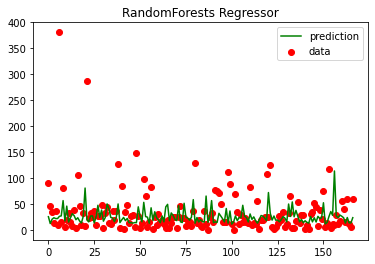

In [ ]:
model_sj = RandomForest(X_train_sj, X_test_sj,y_train_sj,y_test_sj,500,4)


Error Measure  7.158068493150685 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


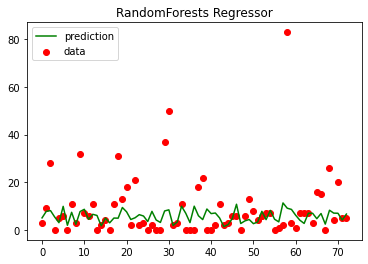

In [ ]:
model_iq = RandomForest(X_train_iq,X_test_iq,y_train_iq,y_test_iq,500,4)

# Submission result

We generate the output file according to the Submission format

Once we have identified the best parameterization we will go on to make an execution of the model and we will graph its results.


In [ ]:
sj_test = test[test['city']=='sj']
sj_test

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.01890,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.01800,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.00150,-0.012400,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,-0.00150,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.05680,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,sj,2013,13,2013-03-26,-0.08740,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,294.675714,301.3,296.4,2.55,78.780000,30.34,15.985714,3.314286,27.542857,7.942857,33.9,22.8,3.5
256,sj,2013,14,2013-04-02,-0.20325,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,301.5,295.9,64.30,81.650000,6.55,15.881429,2.828571,26.642857,6.642857,33.3,22.8,17.6
257,sj,2013,15,2013-04-09,-0.11760,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,294.948571,301.5,297.5,0.70,78.285714,0.00,16.212857,3.171429,27.914286,8.114286,32.8,23.3,9.4
258,sj,2013,16,2013-04-16,0.08275,0.031200,0.135014,0.074857,0.00,298.912857,299.064286,294.678571,300.9,297.3,1.40,77.674286,0.00,15.965714,3.042857,27.728571,6.942857,31.7,23.9,22.9


In [ ]:
iq_test = test[test['city']=='iq']
iq_test

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
260,iq,2010,26,2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,293.7,34.11,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2
261,iq,2010,27,2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,292.2,9.10,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9
262,iq,2010,28,2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,292.5,61.09,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6
263,iq,2010,29,2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,289.3,19.60,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8
264,iq,2010,30,2010-07-30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,290.5,18.93,78.610000,56.30,15.468571,11.771429,27.050,11.850,33.5,16.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,iq,2013,22,2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,292.7,67.60,89.990000,41.12,17.185714,10.100000,27.400,9.050,32.6,21.8,33.0
412,iq,2013,23,2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,291.6,45.70,93.891429,71.52,17.448571,9.657143,27.520,10.720,33.8,21.4,68.0
413,iq,2013,24,2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,290.7,45.22,94.967143,78.96,16.410000,7.385714,27.200,10.075,32.6,21.6,93.2
414,iq,2013,25,2013-06-18,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,297.400000,293.648571,305.9,292.5,4.70,89.057143,39.54,15.137143,8.228571,26.700,8.480,32.2,21.8,34.1


In [ ]:
final_model_prediction_sj = model_sj.predict(sj_test[selected_features])

In [ ]:
final_model_prediction_iq = model_iq.predict(iq_test[selected_features])

1. We carry out the prediction on the test.

In [ ]:
final_model_prediction = np.concatenate((final_model_prediction_sj,final_model_prediction_iq))

Finally we try to visualize how our prediction has turned out with reality.

In [ ]:
# round the result and cast to int
y = np.rint(final_model_prediction) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

res

array([ 18,  17,  19,  25,  15,  33,  23,  32,  24,  25,  24,  39,  28,
        25,  50,  33,  32,  48,  66,  65,  52,  27,  46,  25,  25,  27,
        20,  30,  28,  29,  18,  16,  15,  15,  16,  16,  16,  15,  16,
        18,  16,  16,  15,  16,  16,  15,  16,  16,  16,  16,  13,  13,
        13,  14,  26,  18,  29,  27,  24,  26,  34,  57,  27,  34,  32,
        34,  37,  26,  35,  31,  34,  48,  25,  28,  31,  31,  34,  37,
        31,  36,  22,  27,  29,  23,  20,  24,  17,  17,  21,  21,  26,
        20,  20,  15,  17,  17,  27,  33,  21,  24,  19,  14,  16,  20,
        30,  31,  32,  26,  28, 113,  61,  44,  45,  53, 120, 112,  51,
        66,  40,  91,  65,  91,  76,  81, 105,  45,  45,  47, 100,  27,
        23,  23,  28,  19,  14,  17,  24,  19,  16,  15,  17,  20,  20,
        17,  17,  16,  15,  16,  17,  16,  18,  15,  17,  18,  16,  15,
        13,  22,  15,  24,  31,  29,  35, 110, 126,  61,  48,  55,  27,
       126,  49, 114,  54, 116,  56,  38,  44,  33,  49,  53,  2

3. We build the output file


In [ ]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])


submission.total_cases = res.astype(np.int64)
submission.to_csv("result.csv")

Upload new submission
Woohoo! We processed your submission!
Your score for this submission is:

26.3846
Woo! I scored 26.3846 on 'DengAI: Predicting Disease Spread'!